# Smart Portfolio Allocator - Exploratory Data Analysis

## Overview
This notebook performs exploratory data analysis on the stock market data for building a reinforcement learning-based portfolio allocation system.

## Objectives
1. Load and examine stock price data
2. Calculate key financial metrics (returns, volatility, correlations)
3. Visualize price trends and relationships
4. Identify patterns and characteristics for RL environment design


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 1.26.3


## 1. Data Loading

First, let's load all the stock data from the Files directory.


In [10]:
# Define paths
data_dir = Path("../Files")
print(f"Data directory: {data_dir}")
print(f"Directory exists: {data_dir.exists()}")

# List all CSV files
csv_files = list(data_dir.glob("*.csv"))
print(f"\nFound {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"  - {file.name}")


Data directory: ..\Files
Directory exists: True

Found 26 CSV files:
  - AAL.csv
  - AAPL.csv
  - ALGT.csv
  - ALK.csv
  - AMZN.csv
  - Annexure-I.csv
  - BCS.csv
  - BHC.csv
  - CS.csv
  - DAL.csv
  - DB.csv
  - FB.csv
  - GOOG.csv
  - GS.csv
  - HA.csv
  - IBM.csv
  - JNJ.csv
  - LUV.csv
  - MRK.csv
  - MS.csv
  - MSFT.csv
  - PFE.csv
  - RHHBY.csv
  - SP500.csv
  - UNH.csv
  - WFC.csv


In [15]:
# Function to load and process stock data
def load_stock_data(file_path):
    """Load stock data from CSV file and standardize format."""
    try:
        df = pd.read_csv(file_path)
        
        # Standardize column names (common variations)
        column_mapping = {
            'Date': 'date',
            'DATE': 'date',
            'Date/Time': 'date',
            'Open': 'open',
            'OPEN': 'open',
            'High': 'high', 
            'HIGH': 'high',
            'Low': 'low',
            'LOW': 'low',
            'Close': 'close',
            'CLOSE': 'close',
            'Adj Close': 'adj_close',
            'Adj_Close': 'adj_close',
            'Volume': 'volume',
            'VOLUME': 'volume'
        }
        
        df = df.rename(columns=column_mapping)
        
        # Convert date column with dayfirst=True to handle DD-MM-YYYY format
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='mixed')
            df = df.set_index('date')
        
        return df
        
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load all stock data
stock_data = {}
failed_files = []

for file_path in csv_files:
    stock_name = file_path.stem
    df = load_stock_data(file_path)
    
    if df is not None:
        stock_data[stock_name] = df
        print(f"✓ Loaded {stock_name}: {len(df)} rows, columns: {list(df.columns)}")
    else:
        failed_files.append(stock_name)

print(f"\nSuccessfully loaded {len(stock_data)} stocks")
if failed_files:
    print(f"Failed to load: {failed_files}")


✓ Loaded AAL: 2517 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded AAPL: 2517 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded ALGT: 2524 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded ALK: 2524 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded AMZN: 2524 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded Annexure-I: 24 rows, columns: ['Ticker', 'Industry', 'Company Name']
✓ Loaded BCS: 2712 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded BHC: 2525 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded CS: 2712 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded DAL: 2524 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded DB: 2712 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded FB: 2113 row

## 2. Data Overview

Let's examine the structure and basic statistics of our loaded data.


In [16]:
# Display basic information about each stock
print("=== STOCK DATA OVERVIEW ===\n")

for stock_name, df in stock_data.items():
    print(f"📊 {stock_name.upper()}")
    
    # Check if index is DatetimeIndex
    if isinstance(df.index, pd.DatetimeIndex):
        print(f"   Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    else:
        print(f"   Period: {df.index.min()} to {df.index.max()}")
    
    print(f"   Data points: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Missing values: {df.isnull().sum().sum()}")
    print(f"   Latest close price: ${df['close'].iloc[-1]:.2f}" if 'close' in df.columns else "   No close price data")
    print()

# Check data consistency across stocks
print("=== DATA CONSISTENCY CHECK ===\n")
date_ranges = {}
for stock_name, df in stock_data.items():
    if len(df) > 0 and isinstance(df.index, pd.DatetimeIndex):
        date_ranges[stock_name] = (df.index.min(), df.index.max())

# Find common date range
if date_ranges:
    common_start = max([start for start, end in date_ranges.values()])
    common_end = min([end for start, end in date_ranges.values()])
    print(f"Common trading period: {common_start.strftime('%Y-%m-%d')} to {common_end.strftime('%Y-%m-%d')}")
    
    # Count stocks with data in common period
    stocks_in_common_period = []
    for stock_name, (start, end) in date_ranges.items():
        if start <= common_start and end >= common_end:
            stocks_in_common_period.append(stock_name)
    
    print(f"Stocks with complete data in common period: {len(stocks_in_common_period)}")
    print(f"Stocks: {', '.join(stocks_in_common_period[:10])}{'...' if len(stocks_in_common_period) > 10 else ''}")


=== STOCK DATA OVERVIEW ===

📊 AAL
   Period: 2010-10-01 to 2020-09-30
   Data points: 2517
   Columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
   Missing values: 0
   Latest close price: $12.29

📊 AAPL
   Period: 2010-10-01 to 2020-09-30
   Data points: 2517
   Columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
   Missing values: 0
   Latest close price: $115.81

📊 ALGT
   Period: 2010-10-01 to 2020-09-30
   Data points: 2524
   Columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
   Missing values: 42
   Latest close price: $nan

📊 ALK
   Period: 2010-10-01 to 2020-09-30
   Data points: 2524
   Columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
   Missing values: 42
   Latest close price: $nan

📊 AMZN
   Period: 2010-10-01 to 2020-09-30
   Data points: 2524
   Columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
   Missing values: 42
   Latest close price: $nan

📊 ANNEXURE-I
   Period: 0 to 23
   Data points: 24
   C

## 3. Price Analysis and Visualization

Let's visualize the price trends for key stocks and analyze their movements.


In [20]:
# Create a combined dataset for analysis
def create_combined_dataset(stock_data, price_column='close'):
    """Create a combined dataset with all stock prices."""
    combined_data = {}
    
    for stock_name, df in stock_data.items():
        if price_column in df.columns:
            # Remove duplicate dates, keeping the first occurrence
            if df.index.duplicated().any():
                print(f"⚠ Warning: {stock_name} has {df.index.duplicated().sum()} duplicate dates. Removing duplicates...")
                df = df[~df.index.duplicated(keep='first')]
            
            # Only include stocks with valid price data (not NaN)
            price_series = df[price_column]
            if not price_series.isna().all():  # Only include if there's at least some valid data
                combined_data[stock_name] = price_series
    
    if combined_data:
        # Use pd.concat instead of pd.DataFrame to handle different indices better
        combined_df = pd.concat(combined_data, axis=1)
        combined_df.columns = list(combined_data.keys())
        return combined_df
    else:
        return None

# Create combined dataset
combined_prices = create_combined_dataset(stock_data)
print(f"Combined dataset shape: {combined_prices.shape}")
print(f"Date range: {combined_prices.index.min()} to {combined_prices.index.max()}")
print(f"Stocks included: {list(combined_prices.columns)}")

# Display first few rows
print("\nFirst 5 rows:")
print(combined_prices.head())

⚠ Warning: ALGT has 6 duplicate dates. Removing duplicates...
⚠ Warning: ALK has 6 duplicate dates. Removing duplicates...
⚠ Warning: AMZN has 6 duplicate dates. Removing duplicates...
⚠ Warning: BCS has 6 duplicate dates. Removing duplicates...
⚠ Warning: BHC has 7 duplicate dates. Removing duplicates...
⚠ Warning: CS has 6 duplicate dates. Removing duplicates...
⚠ Warning: DAL has 6 duplicate dates. Removing duplicates...
⚠ Warning: DB has 6 duplicate dates. Removing duplicates...
⚠ Warning: FB has 6 duplicate dates. Removing duplicates...
⚠ Warning: GOOG has 6 duplicate dates. Removing duplicates...
⚠ Warning: GS has 6 duplicate dates. Removing duplicates...
⚠ Warning: HA has 6 duplicate dates. Removing duplicates...
⚠ Warning: IBM has 6 duplicate dates. Removing duplicates...
⚠ Warning: JNJ has 7 duplicate dates. Removing duplicates...
⚠ Warning: LUV has 6 duplicate dates. Removing duplicates...
⚠ Warning: MRK has 7 duplicate dates. Removing duplicates...
⚠ Warning: MS has 6 duplic

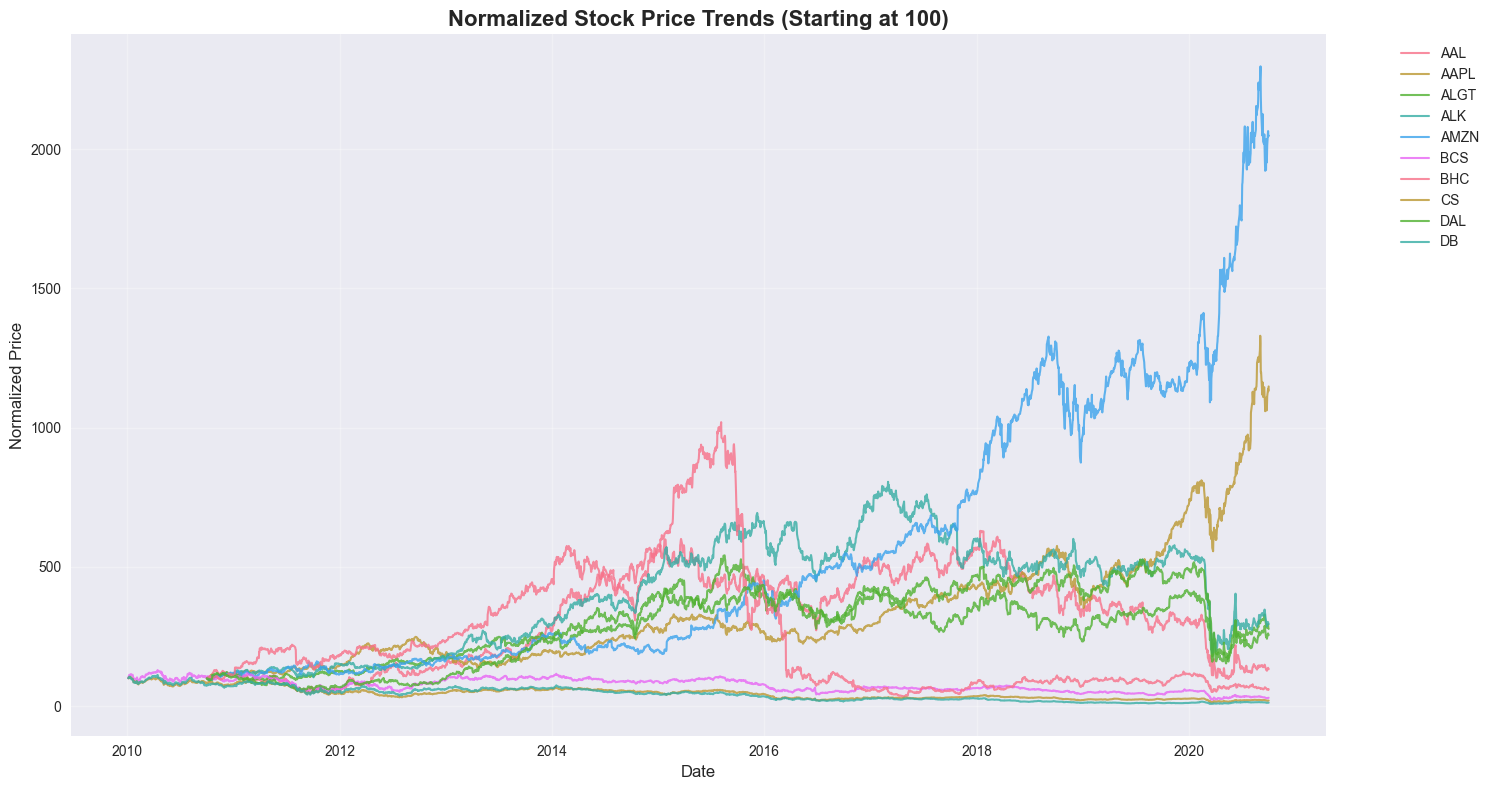


=== PRICE STATISTICS ===
Recent prices (last 5 days):
              AAL        AAPL        ALGT        ALK         AMZN   BCS  \
date                                                                      
2020-09-25  12.29  112.279999  123.760002  36.700001  3095.129883  4.70   
2020-09-28  12.76  114.959999  127.110001  37.540001  3174.050049  4.99   
2020-09-29  12.25  114.089996  121.089996  36.669998  3144.879883  4.96   
2020-09-30  12.29  115.809998  119.800003  36.630001  3148.729980  5.01   
NaT           NaN         NaN         NaN        NaN          NaN   NaN   

              BHC    CS        DAL    DB  
date                                      
2020-09-25  15.30  9.48  29.780001  8.00  
2020-09-28  15.27  9.90  31.340000  8.43  
2020-09-29  14.88  9.83  30.610001  8.27  
2020-09-30  15.54  9.97  30.580000  8.40  
NaT           NaN   NaN        NaN   NaN  

Price ranges:
               AAL         AAPL         ALGT          ALK         AMZN  \
count  2517.000000  2517.0000

In [21]:
# Plot price trends for selected stocks
if combined_prices is not None and len(combined_prices.columns) > 0:
    
    # Select a subset of stocks for visualization (to avoid overcrowding)
    n_stocks_to_plot = min(10, len(combined_prices.columns))
    selected_stocks = combined_prices.columns[:n_stocks_to_plot]
    
    # Normalize prices to start at 100 for better comparison
    normalized_prices = combined_prices[selected_stocks].copy()
    for col in selected_stocks:
        first_price = normalized_prices[col].dropna().iloc[0]
        normalized_prices[col] = (normalized_prices[col] / first_price) * 100
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    for stock in selected_stocks:
        plt.plot(normalized_prices.index, normalized_prices[stock], 
                label=stock, linewidth=1.5, alpha=0.8)
    
    plt.title('Normalized Stock Price Trends (Starting at 100)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Price', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display basic statistics
    print("\n=== PRICE STATISTICS ===")
    print("Recent prices (last 5 days):")
    print(combined_prices[selected_stocks].tail())
    
    print("\nPrice ranges:")
    price_stats = combined_prices[selected_stocks].describe()
    print(price_stats)
    
else:
    print("No price data available for visualization.")


## 4. Returns Analysis

Calculate and analyze returns, which are crucial for portfolio optimization and RL reward design.


Daily returns shape: (2106, 25)
Date range: 2012-05-21 00:00:00 to 2020-09-30 00:00:00

=== RETURNS STATISTICS ===
               AAL         AAPL         ALGT          ALK         AMZN  \
count  2106.000000  2106.000000  2106.000000  2106.000000  2106.000000   
mean      0.000578     0.001021     0.000634     0.000678     0.001459   
std       0.031395     0.017919     0.025289     0.023920     0.019085   
min      -0.252246    -0.128647    -0.283300    -0.232385    -0.109972   
25%      -0.013141    -0.006946    -0.009873    -0.009892    -0.007586   
50%       0.000616     0.000887     0.000220     0.000788     0.001107   
75%       0.014874     0.010101     0.012111     0.011684     0.010978   
max       0.410970     0.119808     0.292428     0.203079     0.141311   

               BCS          BHC           CS          DAL           DB  ...  \
count  2106.000000  2106.000000  2106.000000  2106.000000  2106.000000  ...   
mean     -0.000074     0.000194    -0.000091     0.000836   

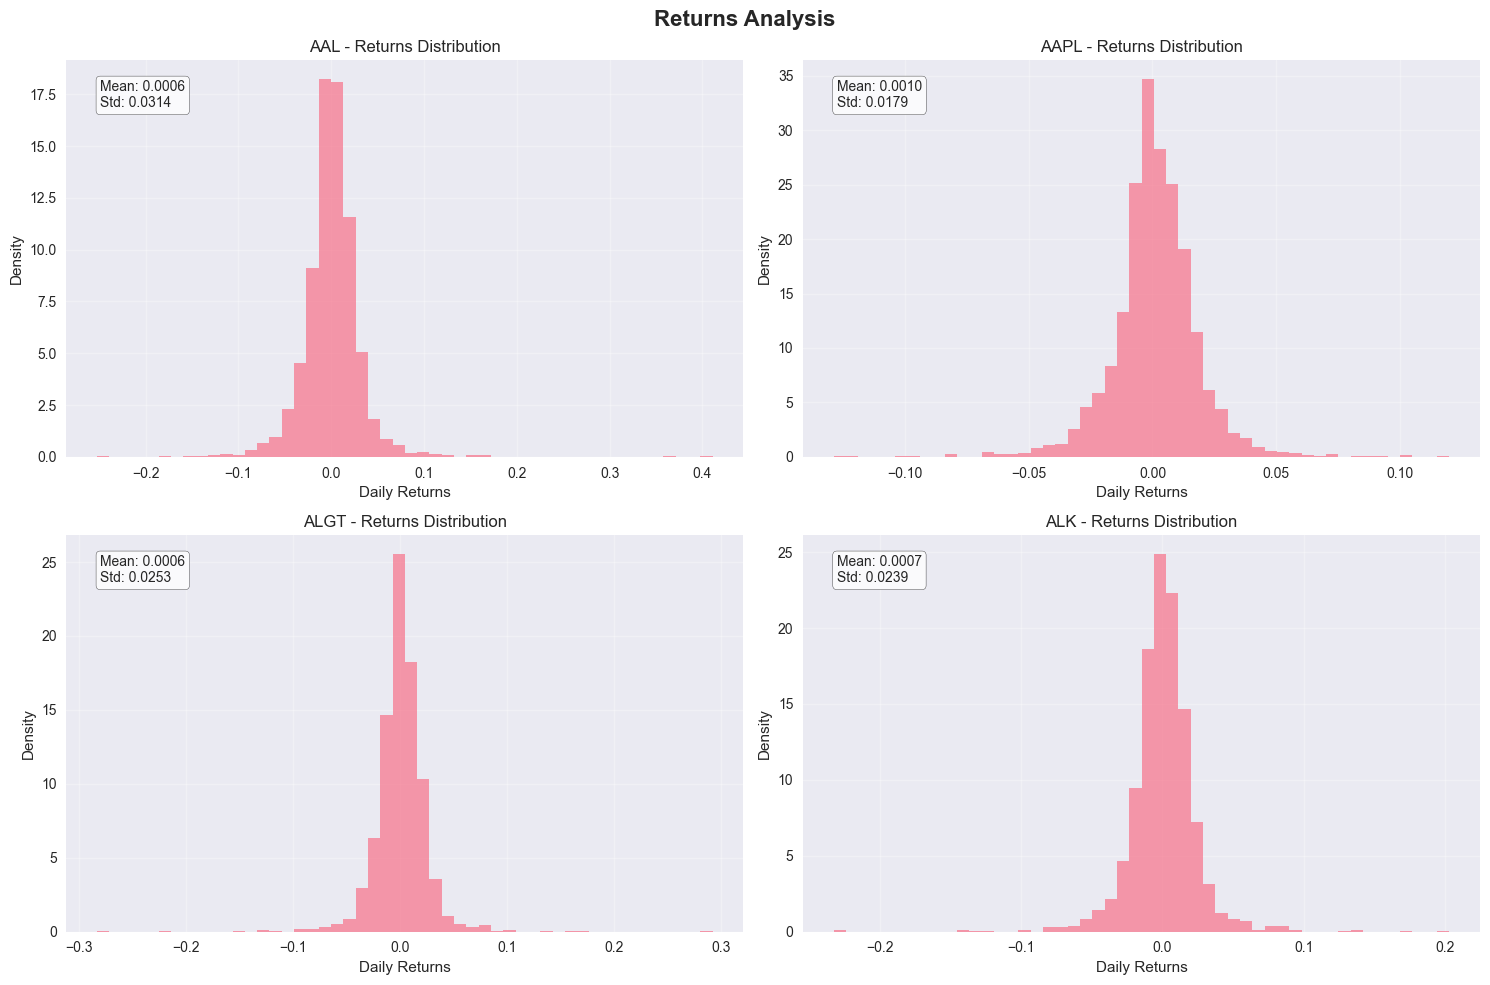

In [22]:
# Calculate returns
def calculate_returns(prices, method='simple'):
    """Calculate returns from price data."""
    if method == 'simple':
        returns = prices.pct_change().dropna()
    elif method == 'log':
        returns = np.log(prices / prices.shift(1)).dropna()
    else:
        raise ValueError("Method must be 'simple' or 'log'")
    return returns

# Calculate daily returns
if combined_prices is not None:
    daily_returns = calculate_returns(combined_prices, method='simple')
    
    print(f"Daily returns shape: {daily_returns.shape}")
    print(f"Date range: {daily_returns.index.min()} to {daily_returns.index.max()}")
    
    # Display returns statistics
    print("\n=== RETURNS STATISTICS ===")
    returns_stats = daily_returns.describe()
    print(returns_stats)
    
    # Check for extreme returns (potential data issues)
    print("\n=== EXTREME RETURNS CHECK ===")
    extreme_threshold = 0.5  # 50% daily return
    extreme_returns = daily_returns[(daily_returns > extreme_threshold) | (daily_returns < -extreme_threshold)]
    
    if len(extreme_returns) > 0:
        print(f"Found {len(extreme_returns)} extreme returns (>50% or <-50%):")
        for idx, row in extreme_returns.iterrows():
            for stock, ret in row.items():
                if abs(ret) > extreme_threshold:
                    print(f"  {idx.strftime('%Y-%m-%d')} {stock}: {ret:.2%}")
    else:
        print("No extreme returns found (>50% or <-50%)")
    
    # Plot returns distribution
    if len(daily_returns.columns) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Returns Analysis', fontsize=16, fontweight='bold')
        
        # Select stocks for detailed analysis
        analysis_stocks = daily_returns.columns[:4] if len(daily_returns.columns) >= 4 else daily_returns.columns
        
        for i, stock in enumerate(analysis_stocks):
            row = i // 2
            col = i % 2
            
            # Histogram of returns
            axes[row, col].hist(daily_returns[stock].dropna(), bins=50, alpha=0.7, density=True)
            axes[row, col].set_title(f'{stock} - Returns Distribution')
            axes[row, col].set_xlabel('Daily Returns')
            axes[row, col].set_ylabel('Density')
            axes[row, col].grid(True, alpha=0.3)
            
            # Add statistics text
            mean_ret = daily_returns[stock].mean()
            std_ret = daily_returns[stock].std()
            axes[row, col].text(0.05, 0.95, f'Mean: {mean_ret:.4f}\nStd: {std_ret:.4f}', 
                              transform=axes[row, col].transAxes, verticalalignment='top',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
else:
    print("No price data available for returns calculation.")


## 5. Correlation Analysis

Analyze correlations between stocks to understand diversification opportunities.


=== CORRELATION ANALYSIS ===
Correlation matrix shape: (25, 25)


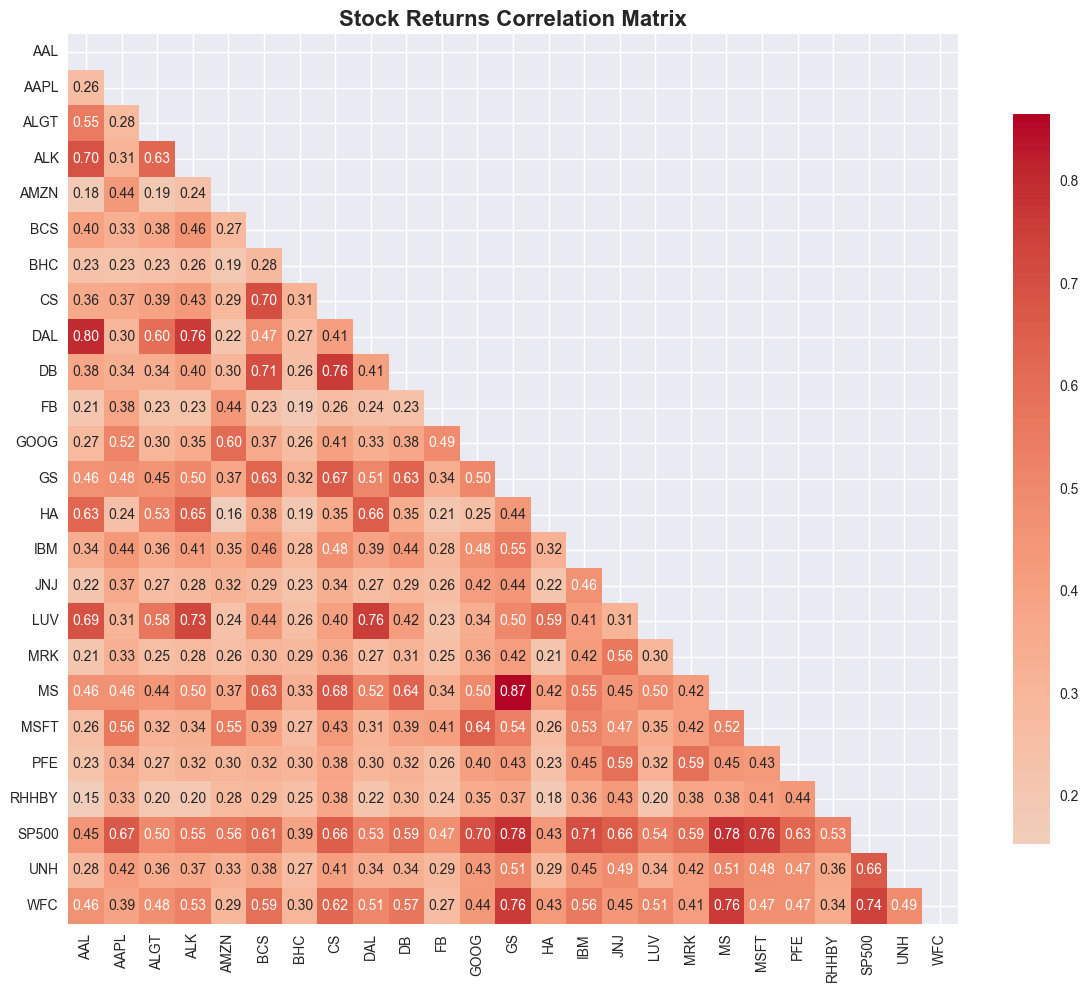


=== HIGHLY CORRELATED PAIRS ===
Found 15 pairs with correlation > 0.7:
  GS - MS: 0.866
  AAL - DAL: 0.800
  GS - SP500: 0.783
  MS - SP500: 0.783
  ALK - DAL: 0.758
  GS - WFC: 0.758
  MS - WFC: 0.758
  CS - DB: 0.758
  MSFT - SP500: 0.757
  DAL - LUV: 0.757
  SP500 - WFC: 0.743
  ALK - LUV: 0.726
  BCS - DB: 0.707
  IBM - SP500: 0.706
  BCS - CS: 0.702

Average correlation: 0.410

=== DIVERSIFICATION INSIGHTS ===
⚠ Moderate diversification - some correlation exists


In [ ]:
# Correlation analysis
if daily_returns is not None and len(daily_returns.columns) > 1:
    
    # Calculate correlation matrix
    correlation_matrix = daily_returns.corr()
    
    print("=== CORRELATION ANALYSIS ===")
    print(f"Correlation matrix shape: {correlation_matrix.shape}")
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Stock Returns Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs
    print("\n=== HIGHLY CORRELATED PAIRS ===")
    high_corr_threshold = 0.7
    
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > high_corr_threshold:
                high_corr_pairs.append((correlation_matrix.columns[i], 
                                      correlation_matrix.columns[j], 
                                      corr_value))
    
    if high_corr_pairs:
        print(f"Found {len(high_corr_pairs)} pairs with correlation > {high_corr_threshold}:")
        for stock1, stock2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {stock1} - {stock2}: {corr:.3f}")
    else:
        print(f"No pairs found with correlation > {high_corr_threshold}")
    
    # Calculate average correlation
    avg_correlation = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean()
    print(f"\nAverage correlation: {avg_correlation:.3f}")
    
    # Diversification analysis
    print("\n=== DIVERSIFICATION INSIGHTS ===")
    if avg_correlation < 0.3:
        print("✓ Good diversification potential - low average correlation")
    elif avg_correlation < 0.6:
        print("⚠ Moderate diversification - some correlation exists")
    else:
        print("⚠ Limited diversification - high correlation between stocks")
        
else:
    print("Insufficient data for correlation analysis (need at least 2 stocks).")


## 6. Risk Metrics

Calculate key risk metrics that will be important for the RL environment design.


=== RISK METRICS SUMMARY ===
Stock      Ann. Ret.  Ann. Vol.  Sharpe   Max DD     VaR 95%   
----------------------------------------------------------------------
AAL        0.146      0.498      0.252    -0.845     -0.044    
AAPL       0.257      0.284      0.834    -0.444     -0.026    
ALGT       0.160      0.401      0.348    -0.717     -0.033    
ALK        0.171      0.380      0.397    -0.765     -0.032    
AMZN       0.368      0.303      1.148    -0.341     -0.027    
BCS        -0.019     0.364      -0.107   -0.804     -0.032    
BHC        0.049      0.588      0.049    -0.968     -0.052    
CS         -0.023     0.331      -0.130   -0.803     -0.030    
DAL        0.211      0.395      0.484    -0.696     -0.034    
DB         -0.091     0.394      -0.282   -0.894     -0.038    
FB         0.300      0.374      0.747    -0.479     -0.033    
GOOG       0.222      0.253      0.799    -0.308     -0.022    
GS         0.128      0.279      0.387    -0.506     -0.026    
HA  

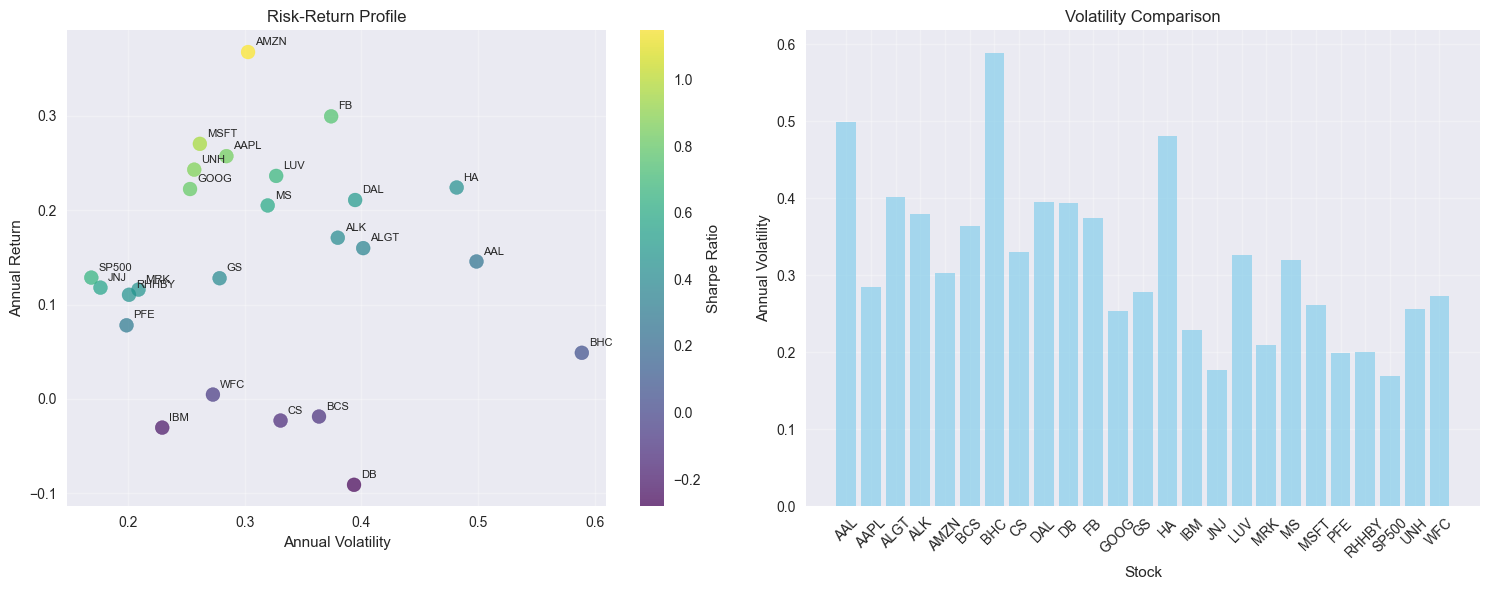


=== PERFORMANCE RANKINGS ===
Best Sharpe Ratio: AMZN (1.148)
Highest Return: AMZN (0.368)
Lowest Volatility: SP500 (0.169)

Stocks with Sharpe Ratio > 1.0: 1
  AMZN: 1.148


In [24]:
# Calculate risk metrics
def calculate_risk_metrics(returns):
    """Calculate various risk metrics for portfolio analysis."""
    metrics = {}
    
    # Annualized metrics (assuming 252 trading days)
    trading_days = 252
    
    for stock in returns.columns:
        stock_returns = returns[stock].dropna()
        
        if len(stock_returns) > 0:
            # Basic metrics
            mean_return = stock_returns.mean()
            volatility = stock_returns.std()
            
            # Annualized metrics
            annual_return = mean_return * trading_days
            annual_volatility = volatility * np.sqrt(trading_days)
            
            # Sharpe ratio (assuming 2% risk-free rate)
            risk_free_rate = 0.02
            sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility if annual_volatility > 0 else 0
            
            # Value at Risk (VaR) - 5th percentile
            var_95 = np.percentile(stock_returns, 5)
            
            # Maximum Drawdown
            cumulative_returns = (1 + stock_returns).cumprod()
            running_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = drawdown.min()
            
            metrics[stock] = {
                'mean_daily_return': mean_return,
                'daily_volatility': volatility,
                'annual_return': annual_return,
                'annual_volatility': annual_volatility,
                'sharpe_ratio': sharpe_ratio,
                'var_95': var_95,
                'max_drawdown': max_drawdown
            }
    
    return metrics

# Calculate risk metrics
if daily_returns is not None and len(daily_returns.columns) > 0:
    risk_metrics = calculate_risk_metrics(daily_returns)
    
    print("=== RISK METRICS SUMMARY ===")
    print(f"{'Stock':<10} {'Ann. Ret.':<10} {'Ann. Vol.':<10} {'Sharpe':<8} {'Max DD':<10} {'VaR 95%':<10}")
    print("-" * 70)
    
    for stock, metrics in risk_metrics.items():
        print(f"{stock:<10} {metrics['annual_return']:<10.3f} {metrics['annual_volatility']:<10.3f} "
              f"{metrics['sharpe_ratio']:<8.3f} {metrics['max_drawdown']:<10.3f} {metrics['var_95']:<10.3f}")
    
    # Create risk-return scatter plot
    if len(risk_metrics) > 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Risk-Return scatter plot
        stocks = list(risk_metrics.keys())
        returns_ann = [risk_metrics[stock]['annual_return'] for stock in stocks]
        volatility_ann = [risk_metrics[stock]['annual_volatility'] for stock in stocks]
        sharpe_ratios = [risk_metrics[stock]['sharpe_ratio'] for stock in stocks]
        
        scatter = ax1.scatter(volatility_ann, returns_ann, c=sharpe_ratios, 
                            cmap='viridis', s=100, alpha=0.7)
        ax1.set_xlabel('Annual Volatility')
        ax1.set_ylabel('Annual Return')
        ax1.set_title('Risk-Return Profile')
        ax1.grid(True, alpha=0.3)
        
        # Add stock labels
        for i, stock in enumerate(stocks):
            ax1.annotate(stock, (volatility_ann[i], returns_ann[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # Colorbar for Sharpe ratio
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Sharpe Ratio')
        
        # Volatility comparison
        ax2.bar(stocks, volatility_ann, alpha=0.7, color='skyblue')
        ax2.set_xlabel('Stock')
        ax2.set_ylabel('Annual Volatility')
        ax2.set_title('Volatility Comparison')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Identify best and worst performers
        print("\n=== PERFORMANCE RANKINGS ===")
        
        # Best Sharpe ratio
        best_sharpe = max(risk_metrics.items(), key=lambda x: x[1]['sharpe_ratio'])
        print(f"Best Sharpe Ratio: {best_sharpe[0]} ({best_sharpe[1]['sharpe_ratio']:.3f})")
        
        # Highest return
        best_return = max(risk_metrics.items(), key=lambda x: x[1]['annual_return'])
        print(f"Highest Return: {best_return[0]} ({best_return[1]['annual_return']:.3f})")
        
        # Lowest volatility
        lowest_vol = min(risk_metrics.items(), key=lambda x: x[1]['annual_volatility'])
        print(f"Lowest Volatility: {lowest_vol[0]} ({lowest_vol[1]['annual_volatility']:.3f})")
        
        # Best risk-adjusted (Sharpe > 1.0)
        good_sharpe = [(stock, metrics['sharpe_ratio']) for stock, metrics in risk_metrics.items() 
                      if metrics['sharpe_ratio'] > 1.0]
        if good_sharpe:
            print(f"\nStocks with Sharpe Ratio > 1.0: {len(good_sharpe)}")
            for stock, sharpe in sorted(good_sharpe, key=lambda x: x[1], reverse=True):
                print(f"  {stock}: {sharpe:.3f}")
        else:
            print("\nNo stocks with Sharpe Ratio > 1.0")
            
else:
    print("No data available for risk metrics calculation.")


## 7. RL Environment Design Insights

Based on our analysis, let's summarize key insights for designing the RL environment.


In [25]:
# Summary and recommendations for RL environment design
print("=== REINFORCEMENT LEARNING ENVIRONMENT DESIGN INSIGHTS ===\n")

if combined_prices is not None and daily_returns is not None:
    
    # 1. State Space Design
    print("1. STATE SPACE RECOMMENDATIONS:")
    print(f"   • Number of assets: {len(combined_prices.columns)}")
    print(f"   • Time period: {len(combined_prices)} days")
    print("   • State features to consider:")
    print("     - Current portfolio weights (normalized)")
    print("     - Recent price changes (e.g., last 5-20 days)")
    print("     - Technical indicators (RSI, MACD, moving averages)")
    print("     - Risk metrics (volatility, correlation)")
    print("     - Market regime indicators")
    
    # 2. Action Space Design
    print("\n2. ACTION SPACE RECOMMENDATIONS:")
    print("   • Discrete actions: Buy/Hold/Sell for each asset")
    print("   • Continuous actions: Portfolio weight adjustments")
    print("   • Action constraints: Portfolio weights sum to 1.0")
    print("   • Transaction costs: Include in reward function")
    
    # 3. Reward Function Design
    print("\n3. REWARD FUNCTION RECOMMENDATIONS:")
    print("   • Primary: Risk-adjusted returns (Sharpe ratio)")
    print("   • Secondary: Portfolio return, volatility penalty")
    print("   • Transaction costs: Penalty for frequent rebalancing")
    print("   • Drawdown penalty: Avoid large losses")
    
    # 4. Data Preprocessing
    print("\n4. DATA PREPROCESSING RECOMMENDATIONS:")
    print("   • Normalize prices to returns for stationarity")
    print("   • Handle missing values (forward fill or interpolation)")
    print("   • Create train/validation/test splits")
    print("   • Consider rolling window approach for training")
    
    # 5. Environment Parameters
    print("\n5. ENVIRONMENT PARAMETERS:")
    print(f"   • Episode length: {min(252, len(combined_prices)//10)} days (1 trading year)")
    print("   • Initial portfolio: Equal weights or cash")
    print("   • Rebalancing frequency: Daily or weekly")
    print("   • Transaction costs: 0.1% - 0.5% per trade")
    
    # 6. Model Selection
    print("\n6. RL ALGORITHM RECOMMENDATIONS:")
    print("   • DQN: Good for discrete action spaces")
    print("   • PPO/A3C: Better for continuous action spaces")
    print("   • SAC/TD3: Advanced continuous control")
    print("   • Consider ensemble methods for robustness")
    
    # 7. Validation Strategy
    print("\n7. VALIDATION STRATEGY:")
    print("   • Time-series split (no shuffle)")
    print("   • Walk-forward analysis")
    print("   • Out-of-sample testing")
    print("   • Compare against benchmark (equal weights, buy & hold)")
    
else:
    print("Insufficient data for RL environment design recommendations.")
    print("Please ensure stock data is properly loaded before proceeding.")

print("\n" + "="*60)
print("NEXT STEPS:")
print("1. Implement the RL environment class")
print("2. Choose and implement RL algorithm")
print("3. Design reward function based on insights")
print("4. Train and validate the model")
print("5. Backtest on historical data")
print("="*60)


=== REINFORCEMENT LEARNING ENVIRONMENT DESIGN INSIGHTS ===

1. STATE SPACE RECOMMENDATIONS:
   • Number of assets: 25
   • Time period: 2706 days
   • State features to consider:
     - Current portfolio weights (normalized)
     - Recent price changes (e.g., last 5-20 days)
     - Technical indicators (RSI, MACD, moving averages)
     - Risk metrics (volatility, correlation)
     - Market regime indicators

2. ACTION SPACE RECOMMENDATIONS:
   • Discrete actions: Buy/Hold/Sell for each asset
   • Continuous actions: Portfolio weight adjustments
   • Action constraints: Portfolio weights sum to 1.0
   • Transaction costs: Include in reward function

3. REWARD FUNCTION RECOMMENDATIONS:
   • Primary: Risk-adjusted returns (Sharpe ratio)
   • Secondary: Portfolio return, volatility penalty
   • Transaction costs: Penalty for frequent rebalancing
   • Drawdown penalty: Avoid large losses

4. DATA PREPROCESSING RECOMMENDATIONS:
   • Normalize prices to returns for stationarity
   • Handle mi